In [1]:
import random
import time

import casadi
import numpy as np 
import torch
from scipy import integrate
import pandas as pd
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation



In [2]:
def get_h_k(new_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    integrand = lambda *x : np.prod(np.cos(np.array(x)*np.array(new_k))**2)
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return np.sqrt(integral_result)

def get_fourier_fn_k(new_k, U_shape):
    # only torch one because we need gradient
    h_k = torch.tensor(get_h_k(new_k, U_shape))
    return lambda x : (1/h_k) * torch.prod(torch.cos(x*torch.tensor(new_k)))

def casadi_prod(x, n):
    result = 1
    for i in range(n):
        result *= x[i] 
    return result

def get_casadi_fourier_fn_k(new_k, U_shape):
    h_k = get_h_k(new_k, U_shape)
    return lambda x : (1/h_k) * casadi_prod(casadi.cos(x*casadi.MX(new_k)), len(U_shape))

def get_lambda_k(new_k, n):
    s = (n+1)/2
    lambda_k = 1 / (1 + np.linalg.norm(new_k)**2)**s
    return lambda_k

def get_mu_k(mu_dist, f_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    # is mu defined everywhere in the bounds
    integrand = lambda *x: mu_dist(np.array(x)) * f_k(torch.tensor(x)).numpy()
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return integral_result

def get_grad_fourier_fn_k(fourier_k):
    return lambda x: torch.autograd.functional.jacobian(fourier_k, x)
    
def get_functions_k(k, mu_dist, U_shape, N):
    n = len(U_shape)
    new_k = np.array(k)*np.pi/np.array(U_shape)
    fourier_k = get_fourier_fn_k(new_k, U_shape)
    grad_fourier_k = get_grad_fourier_fn_k(fourier_k)
    lambda_k = get_lambda_k(new_k, n)
    mu_k = get_mu_k(mu_dist, fourier_k, U_shape)
    return {'fourier_k': fourier_k, 
            'grad_fourier_k': grad_fourier_k, 
            'mu_k': mu_k, 
            'C_k': np.zeros(N, 1),
            'lambda_k': lambda_k}

def get_functions(U_shape, mu_dist, K, N):
    n = len(U_shape)
    return {k: get_functions_k(k, mu_dist, U_shape, N) for k in np.ndindex(*[K]*n)}

def calculate_ergodicity(k_bands, lambd, c_k, mu):
    e = 0
    for k in k_bands:
        e += lambd[k]*(c_k[k]-mu[k])**2
    return e



In [3]:
class Agent:
    def __init__(self, index, N, position, U_shape, umax, k_bands, eps=1e-5): #mm_order=1
        """
        index : number identifier, used in adjacency matrix
        position : initial position, dim n
        U_shape : movement space
        N : number of agents
        umax : max control
        k_bands : the bands it listens to
        eps : boundary distances
        mm_order : 1 for first order (default), 2 for second order
        """
        self.index = index # identifier
        self.x_log = [position] # position log
        self.v_log = [np.zeros(len(U_shape))] # velocity log
        self.u_log = [np.zeros(len(U_shape))] # control log

        self.U_shape = U_shape
        self.n = len(U_shape)
        self.totalNum = N   # total number of agents
        self.N = N
        e_init = 0
        for k in k_bands:
            e_init += lambd[k]*(fourier[k](torch.tensor(position)).numpy()-mu[k])**2
        self.e_log = [e_init] # ergodicity log

        self.umax = umax 
        # if mm_order == 2:
        #     self.vmax = self.umax
        #     self.umax = 10*self.umax
        #     self.c = 0.2 # weighting for second order dynamics
        
        # self.mm_order = mm_order
        self.k_bands = k_bands
        self.eps = eps

        
        self.c_k = {k : fourier[k](torch.tensor(position)).numpy() for k in k_bands} # shared
        self.c_k_log = [self.c_k]
        self.agent_c_k = {k : fourier[k](torch.tensor(position)).numpy() for k in k_bands} # used for calculating overall ergodicity
        # when communicating, just update the old c_k with the shared value
        # NOT averaged

    def update_shared_c_k(self, new_values):
        self.c_k = new_values
        self.c_k_log.append(self.c_k)

    def update_adj_neighbors(self, new_value):
        self.N = new_value

    def recalculate_c_k(self, x_pred=None):
        """ 
        x_pred is if want to see how c_k will change if we go to predicted value
            but don't actually want to change anything
        """
        if x_pred is not None:
            prev_x = casadi.MX(self.x_log[-1])
            curr_x = x_pred
            fourier_fn = casadi_fourier
            new_c_k = {}
            new_agent_c_k = {}
        else:
            prev_x = torch.tensor(self.x_log[-2])
            curr_x = torch.tensor(self.x_log[-1])
            fourier_fn = fourier
            new_c_k = self.c_k
            new_agent_c_k = self.agent_c_k

        for k in self.k_bands:
            average_f_k = (1/2)*(fourier_fn[k](prev_x) + fourier_fn[k](curr_x))
            if x_pred is None:
                average_f_k = average_f_k.numpy()
            new_c_k[k] = (self.c_k[k]*t + average_f_k*delta_t)/(t+delta_t)
            new_agent_c_k[k] = (self.agent_c_k[k]*t + average_f_k*delta_t)/(t+delta_t)

        return new_c_k, new_agent_c_k

    def control(self, t, delta_t, c_k_pred = None):
        """ returns new control """
        pass 
    def move(self, u, t, delta_t):
        """ returns new movement given u control"""
        pass
    def update_move(self, m):
        """ updates u_log, x_log based off of u and movement """
        pass

    def apply_dynamics(self, t, delta_t):
        u = self.control(t, delta_t)
        x = self.move(u, t, delta_t)
        self.u_log.append(u)
        self.update_move(x)

        self.recalculate_c_k()
        e = calculate_ergodicity(self.k_bands, lambd, self.c_k, mu)
        self.e_log.append(e)


    def apply_dynamics_old(self, t, delta_t):
        """ Prior to apply_dynamics is communication step  -- updates c_k and Neighbors """
        """ Movement and Control Calculation """
        B = torch.zeros(self.n) 
        for k in self.k_bands: # np.ndindex(*[K]*n):
            S_k = self.totalNum*t*(self.c_k[k] - mu[k])
            grad_f_k = grad_fourier[k]
            B += lambd[k]*S_k*grad_f_k(self.x_log[-1])   

        if self.mm_order == 2:
            B = self.c*self.v_log[-1] + B

        if (torch.norm(B) < self.eps 
            or (self.x_log[-1] < self.eps).any() 
            or (torch.tensor(self.U_shape) - self.x_log[-1] < self.eps).any()):
            print("Agent: ", self.index, " had oh no at time ", t)
            
            U_center = torch.tensor(self.U_shape)*0.5
            if (U_center == self.x_log[-1]).all():
                # move in random direction away from center 
                assert(self.x_log[-1].size == self.n)
                B = torch.zeros(self.n)
                r_idx = 0
                # r_idx = random.randrange(self.n)
                B[r_idx] = 1
                
            else:
                # aim towards center if not already at center
                B = -1 * (U_center - self.x_log[-1])
        " Control "
        u = -self.umax* B / torch.norm(B)

        if self.mm_order == 1:
            x_new = self.x_log[-1] + u*delta_t
            v_new = u 
        elif self.mm_order == 2:
            x_new = self.x_log[-1] + self.v_log[-1]*delta_t + u*(delta_t**2)/2
            v_new = self.v_log[-1] + u*delta_t
            if torch.norm(v_new) > self.vmax:
                v_new = v_new/torch.norm(v_new)*self.vmax

        self.u_log.append(u)
        self.v_log.append(v_new)
        self.x_log.append(x_new)

        """ Calculate c_k"""
        for k in self.k_bands:
            average_f_k = (1/2)*(fourier[k](self.x_log[-2]) + fourier[k](self.x_log[-1]))
            self.c_k[k] = (self.c_k[k]*t + average_f_k*delta_t)/(t+delta_t)

            self.agent_c_k[k] = (self.agent_c_k[k]*t + average_f_k*delta_t)/(t+delta_t)

        """ Calculate local ergodicity -- before c_k are shared or after shared maybe should 
            wait for communication"""
        e = 0
        for k in self.k_bands:
            e += lambd[k]*(self.c_k[k]-mu[k])**2
        self.e_log.append(e)

class mm_Agent(Agent):
    def __init__(self, index, N, position, U_shape, umax, k_bands, eps=1e-5, mm_order=1):
        super().__init__(index, N, position, U_shape, umax, k_bands, eps=eps)
        assert(mm_order == 1 or mm_order == 2)
        self.mm_order = mm_order 
        if mm_order == 2:
            self.vmax = self.umax
            self.umax = 10*self.umax
            self.c = 0.2
        self.m = self.n

    def control(self, t, delta_t, c_k_pred = None):
        c_k = self.c_k 
        norm = np.linalg.norm

        B = np.zeros(self.n) 
        for k in self.k_bands: # np.ndindex(*[K]*n):
            S_k = self.totalNum*t*(c_k[k] - mu[k])
            grad_f_k = grad_fourier[k]
            B += lambd[k]*S_k*grad_f_k(torch.tensor(self.x_log[-1])).detach().numpy()   

        if self.mm_order == 2:
            B = self.c*self.v_log[-1] + B

        if (norm(B) < self.eps 
            or (self.x_log[-1] < self.eps).any() 
            or (np.array(self.U_shape) - self.x_log[-1] < self.eps).any()):
            print("Agent: ", self.index, " had oh no at time ", t)
            
            U_center = np.array(self.U_shape)*0.5
            if (U_center == self.x_log[-1]).all():
                # move in random direction away from center 
                assert(self.x_log[-1].size == self.n)
                B = np.zeros(self.n)
                r_idx = 0
                # r_idx = random.randrange(self.n)
                B[r_idx] = 1
                
            else:
                # aim towards center if not already at center
                B = -1 * (U_center - self.x_log[-1])
        " Control "
        u = -self.umax * B / norm(B)
        return u 

    def move(self, u, t, delta_t, is_pred=False):
        norm = np.linalg.norm
        prev_x = self.x_log[-1]
        if self.mm_order == 2:
            prev_v = self.v_log[-1]

        if is_pred:
            norm = casadi.norm_2
            prev_x = casadi.MX(prev_x)
            if self.mm_order == 2:
                prev_v = casadi.MX(prev_v)

        if self.mm_order == 1:
            x_new = prev_x + u*delta_t
            v_new = u 
        elif self.mm_order == 2:
            x_new = prev_x + prev_v*delta_t + u*(delta_t**2)/2
            v_new = prev_v + u*delta_t
            # if norm(v_new) > self.vmax:
            #     v_new = v_new/norm(v_new)*self.vmax
            # assert(norm(v_new) != 0)
            # NEW
            v_new = v_new/norm(v_new)*self.vmax

        if is_pred:
            return x_new 
        else:
            return x_new, v_new

    def update_move(self, m):
        x_new, v_new = m
        self.x_log.append(x_new)
        self.v_log.append(v_new)

# casadi optimal first/second order agent???

def runge_kutta(f, x_0, u, t, delta_t):
    # f, u are functions
    k_1 = delta_t*f(x_0, u(t))
    k_2 = delta_t*f(x_0 + 0.5*k_1, u(t + 0.5*delta_t))
    k_3 = delta_t*f(x_0 + 0.5*k_2, u(t + 0.5*delta_t))
    k_4 = delta_t*f(x_0 + k_3, u(t + delta_t))
    return x_0 + k_1/6 + k_2/3 + k_3/3 + k_4/6

class linear_Agent(Agent):
    def __init__(self, index, N, position, U_shape, umax, k_bands, A, B, m, eps=1e-5):
        super().__init__(index, N, position, U_shape, umax, k_bands, eps=eps)
        # x'(t) = Ax(t) + Bu(t)
        
        self.A = A # nxn
        self.m = m
        self.u_log = [np.zeros(self.m)]
        self.B = B # nxm
        self.c_opti = None

    def control(self, t, delta_t):
        c_opti = casadi.Opti()
        self.c_opti = c_opti
        u = c_opti.variable(self.m)
        ## likely this issue, can prob easily be fixed component wise thing
        # NEWNEW first remove umax constraint
        c_opti.subject_to( u <= self.umax )
        c_opti.subject_to( u >= -self.umax )
        # check to make sure new move is within bounds
        x_pred = self.move(u, t, delta_t, is_pred=True)
        c_opti.subject_to( x_pred >= 0 )
        c_opti.subject_to( x_pred <= np.array(self.U_shape) )
        c_opti.set_initial(u, self.u_log[-1])
        
        c_k_pred, _ = self.recalculate_c_k(x_pred=x_pred)
        c_opti.minimize(calculate_ergodicity(self.k_bands, lambd, c_k_pred, mu))

        p_opts = {}
        s_opts = {'print_level': 0}
        c_opti.solver('ipopt', p_opts, s_opts)
        sol = c_opti.solve() 
        return sol.value(u)

    def move(self, u, t, delta_t, is_pred=False):
        # x'(t) = Ax(t) + Bu(t) assumes u(t) = u(t+delta_t)
        # x(t + delta_t) = x(t) +  delta_t*(Ax(t) + Bu(t))
        prev_x = self.x_log[-1]
        A = self.A
        B = self.B
        if is_pred:
            prev_x = casadi.MX(prev_x)
            A = casadi.MX(A)
            B = casadi.MX(B)
        else:
            u = np.array(u).reshape(self.m)
         
        x_new = prev_x + delta_t*(A@prev_x + B@u)

        return x_new

    def update_move(self, m):
        x_new = m
        self.x_log.append(x_new)


p_total:  0.18140542135542154
p_total:  0.1863622475404353
p_total:  0.36045153878131936
p_total:  0.5740085098310393


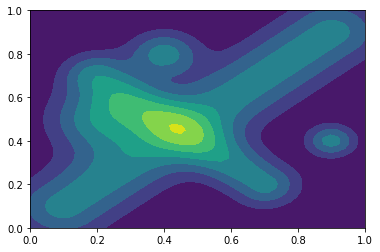

In [4]:
""" Probability Distribution """
def normalize_mu(p):
    p_total, _ = integrate.nquad(lambda *x: p(np.array(x)), [[0, 1], [0, 1]])
    print("p_total: ", p_total)
    return lambda x: p(x)/p_total

def line(x, p1, p2, r):
    p12 = p2-p1
    mid = (p1+p2)/2
    n = np.array([-p12[1], p12[0]])
    n = n / np.linalg.norm(n)
    dist_p12 = np.dot((x-p1), n)**2
    dist_p1 = sum((x-p1)**2)
    dist_p2 = sum((x-p2)**2)
    if np.dot((x-p1), p12) > 0 and np.dot((x-p2), -p12) > 0:
        dist_seg = dist_p12
    else:
        dist_seg = min(dist_p1, dist_p2)
    return np.exp(r * dist_seg)

def unnorm_p1(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))
p1 = normalize_mu(unnorm_p1)

def unnorm_p2(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.3)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.65)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.3, 0.55]))**2))
p2 = normalize_mu(unnorm_p2)

def unnorm_p3(x):
    return np.exp(-25 * np.sum((x[:2] - 0.3)**2)) \
            + np.exp(-100 * np.sum((x[:2] - 0.65)**2)) \
            + np.exp(-50.5 * np.sum((x[:2] - np.array([0.3, 0.55]))**2)) \
            + np.exp(-200 * np.sum((x[:2] - 0.2)**2)) \
            + np.exp(-50 * np.sum((x[:2] - 0.75)**2)) \
            + np.exp(-150 * np.sum((x[:2] - np.array([0.2, 0.75]))**2)) \
            + np.exp(-150 * np.sum((x[:2] - np.array([0.5, 0.5]))**2)) \
            + np.exp(-300 * np.sum((x[:2] - np.array([0.8, 0.2]))**2)) \
            + np.exp(-200 * np.sum((x[:2] - np.array([0.9, 0.3]))**2))
p3 = normalize_mu(unnorm_p3)

def unnorm_p4(x):
    return line(x, np.array([0.2, 0.7]), np.array([0.7, 0.2]), -100) \
            + line(x, np.array([0.1, 0.1]), np.array([0.9, 0.9]), -50) \
            + np.exp(-200 * np.sum((x[:2] - np.array([0.9, 0.4]))**2)) \
            + np.exp(-100 * np.sum((x[:2] - np.array([0.4, 0.8]))**2)) \
            + np.exp(-50 * np.sum((x[:2] - np.array([0.2, 0.5]))**2)) 
p4 = normalize_mu(unnorm_p4)

# Grid and Display
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T


plt.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))
plt.contourf(X, Y, np.array(list(map(p2, _s))).reshape(X.shape)) 
plt.contourf(X, Y, np.array(list(map(p3, _s))).reshape(X.shape))      
plt.contourf(X, Y, np.array(list(map(p4, _s))).reshape(X.shape))    




(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)


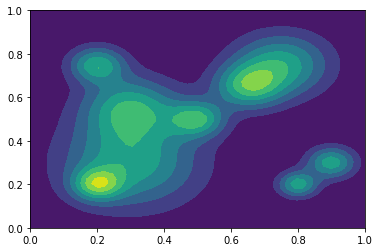

In [5]:
""" Parameters """
# x = [np.array([0.54,0.3]), np.array([0.2, 0.7]), np.array([0.8, 0.1]),
#      np.array([0.7,0.3]), np.array([0.3, 0.7]), np.array([0.9, 0.3]),
#      np.array([0.1,0.2]), np.array([0.2, 0.3]), np.array([0.9, 0.8])]
x = [np.array([0.54,0.3]), np.array([0.2, 0.7]), np.array([0.8, 0.1]),
     np.array([0.7,0.3]), np.array([0.3, 0.7]), np.array([0.9, 0.3]),
     np.array([0.1,0.2]), np.array([0.2, 0.3]), np.array([0.9, 0.8]), np.array([0.4, 0.5])]

U_shape=(1, 1)
n = len(U_shape)
mu_dist=p3
plt.contourf(X, Y, np.array(list(map(mu_dist, _s))).reshape(X.shape)) 

N=len(x)
delta_t=0.01
K=10
u_max=0.5
num_iter= 2000
O = np.ones((3, 3)) # A = 1 full communication
I = np.diag(np.ones(3)) # A = Id isolation
P = np.array([[1, 1, 0], # A = P
                  [1, 1, 0],
                  [0, 0, 1]])

C = np.array([[1, 1, 0], # A = C
                  [1, 1, 1],
                  [0, 1, 0]]) # some weird pairing
# Also A = Lr : communicates with things within radius r
A = P

casadi_fourier = {}
fourier = {}
grad_fourier = {}
lambd = {}
mu = {}
for k in np.ndindex(*[K]*n):
    print(k)
    new_k = np.array(k)*np.pi/np.array(U_shape)
    casadi_fourier[k] = get_casadi_fourier_fn_k(new_k, U_shape)
    fourier[k] = get_fourier_fn_k(new_k, U_shape)
    grad_fourier[k] = get_grad_fourier_fn_k(fourier[k])
    lambd[k] = get_lambda_k(new_k, n)
    mu[k] = get_mu_k(mu_dist, fourier[k], U_shape)



In [6]:
# filename="mm_ergodic_order2_casadi" 
# agents = [mm_Agent(i, N, x[i], U_shape, u_max, list(np.ndindex(*[K]*n)), mm_order=2) for i in range(N)]
num_iter= 1000
filename="multiagents{}_p3_casadi".format(N) 
# A = [np.array([[0, -0.5], [0.5, 0]]), np.array([[-0.5, 0], [0, -0.5]]), np.array([[-0.5, 0.5], [0.5, -0.5]])]
# B = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
# m = [len(b) for b in B]
# # for linear, umax should be bigger than the max value of the vector field at the very least
# linear_agents = [linear_Agent(i, N, x[i], U_shape, 2, list(np.ndindex(*[K]*n)), A[i], B[i], m[i]) for i in range(3)]
# mm1_agents = [mm_Agent(3+i, N, x[3+i], U_shape, u_max, list(np.ndindex(*[K]*n)), mm_order=1) for i in range(3)]
# mm2_agents = [mm_Agent(6+i, N, x[6+i], U_shape, u_max, list(np.ndindex(*[K]*n)), mm_order=2) for i in range(3)]
# agents = linear_agents + mm1_agents + mm2_agents

mm1_agents = [mm_Agent(i, N, x[i], U_shape, u_max, list(np.ndindex(*[K]*n)), mm_order=1) for i in range(5)]
mm2_agents = [mm_Agent(5+i, N, x[5+i], U_shape, u_max, list(np.ndindex(*[K]*n)), mm_order=2) for i in range(5)]
agents = mm1_agents + mm2_agents

In [7]:
def oneminussqr_metric(x):  
    return 1 - (x-1)**2
def oneminusoneover_metric(x, a): 
    return 1 - 1/(a*(x+1/a))  
  
overall_e_log = []
A_log = []
for i in range(0, num_iter):
    t = i*delta_t # [time, time+time_step]

    """ Communication -- Local Broadcasting -- Creates Adjacency Matrix """
    # radius = 0.15
    # A = np.zeros((N, N))
    # for j in range(0, N):
    #     for k in range(j, N):
    #         if np.linalg.norm(agents[j].x_log[-1] - agents[k].x_log[-1]) < radius:
    #             if i%(num_iter//10) == 0:
    #                 print("Agent ", k, " and Agent ", j, "communication")
    #             A[k][j] = 1
    #             A[j][k] = 1 

    """ Casadi Optimization -- Optimal Adjacency Matrix """
    elt_metric = oneminussqr_metric
    r = 2
    
    opti = casadi.Opti()
    A_opt = opti.variable(N, N, 'symmetric')
    
    u_opt = []
    for j in range(N):
        u_opt.append(opti.variable(agents[j].m))

    # Constraints
    opti.subject_to(casadi.vec(A_opt) >= 0)                       # elements nonnegative
    opti.subject_to(casadi.vec(A_opt) <= 1)                       # elements bounded by 1
    opti.subject_to(A_opt@np.ones(N) == 1)                        # rows sum to 1
    
    for j in range(N):
        opti.subject_to(u_opt[j] > 0)
        opti.subject_to(u_opt[j] <= agents[j].umax)

    opti.set_initial(A_opt, np.diag(np.ones(N)))

    # Average Metric sum((Ac - ave(c))^2)
    avmetric = 0
    c_k_pred = [{} for j in range(N)]
    for k in np.ndindex(*[K]*n):
        ck = np.array([agents[j].c_k[k] for j in range(N)])
        ck_sum = casadi.sum1(ck)*np.ones(N)
        # can try abs sum also
        ck_new = A_opt@ck
        avmetric += casadi.sum1(((ck_new - ck_sum)**2))
        for j in range(N):
            c_k_pred[j][k] = ck_new[j]         
    # Sparse Metric -- Average element penalization
    sparsemetric = casadi.sum1(casadi.sum2(elt_metric(A_opt)))/A_opt.numel()    
    # Ergodic Metric
    local_ergodicmetric = 0
    
    for j in range(N):
        x_pred = agents[j].move(u_opt[j], t, delta_t, is_pred=True)
        new_c_k_pred, new_agent_c_k_pred = agents[j].recalculate_c_k(x_pred=x_pred)
        local_ergodicmetric += calculate_ergodicity(agents[j].k_bands, lambd, new_c_k_pred, mu)

    opti.minimize(avmetric + sparsemetric + local_ergodicmetric)
    # opti.minimize(sparsemetric + local_ergodicmetric)


    p_opts = {}
    s_opts = {'print_level': 0}
    opti.solver('ipopt', p_opts, s_opts)
    sol = opti.solve()

    A = sol.value(A_opt).round(r)
 
    """ Communication -- given Adjacency Matrix A """
    A_log.append(A)
    sharec = {}

    A_neighbors = A @ np.ones(N)
    for k in np.ndindex(*[K]*n):
        # what to do if agent doesnt have k band
        c_k = np.array([agents[j].c_k[k] for j in range(N)])
        # sharec[k] -> c_k as t -> infty

        sharec[k] = (A @ c_k) / A_neighbors
 
    for j in range(N):
        agents[j].update_shared_c_k({k: sharec[k][j] for k in agents[j].k_bands})
        # agents[j].update_adj_neighbors(A_neighbors[j])

    """ Calculate overall ergodicity -- Not used in actual? """
    e = 0
    for k in np.ndindex(*[K]*n):
        ave_c_k = (1/N)*sum([agents[j].agent_c_k[k] for j in range(N)])
        e += lambd[k]*(ave_c_k-mu[k])**2
    overall_e_log.append(e)  
 
    """ Agent Moving """
    for j in range(N):    
        agents[j].apply_dynamics(t, delta_t)        




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  16.86ms (  1.30ms)  16.83ms (  1.29ms)        13
       nlp_g  | 201.00us ( 15.46us) 198.50us ( 15.27us)        13
  nlp_grad_f  |  31.21ms (  2.23ms)  31.20ms (  2.23ms)        14
  nlp_hess_l  | 108.52ms (  9.04ms) 108.12ms (  9.01ms)        12
   nlp_jac_g  | 775.00us ( 55.36us) 779.20us ( 55.66us)        14
       total  | 174.05ms (174.05ms) 185.33ms (185.33ms)         1
Agent:  0  had oh no at time  0.0
Agent:  1  had oh no at time  0.0
Agent:  2  had oh no at time  0.0
Agent:  3  had oh no at time  0.0
Agent:  4  had

/home/enko/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Agent:  5  had oh no at time  0.0
Agent:  6  had oh no at time  0.0
Agent:  7  had oh no at time  0.0
Agent:  8  had oh no at time  0.0
Agent:  9  had oh no at time  0.0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  17.79ms (  1.37ms)  17.75ms (  1.37ms)        13
       nlp_g  | 184.00us ( 14.15us) 182.30us ( 14.02us)        13
  nlp_grad_f  |  30.92ms (  2.21ms)  30.86ms (  2.20ms)        14
  nlp_hess_l  | 106.73ms (  8.89ms) 106.37ms (  8.86ms)        12
   nlp_jac_g  | 745.00us ( 53.21us) 750.50us ( 53.61us)        14
       total  | 169.30ms (169.30ms) 168.62ms (168.62ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  19.49ms (  1.39ms)  19.49ms (  1.39ms)        14
       nlp_g  | 192.00us ( 13.71us) 189.10us ( 13.51us)        14
  nlp_grad_f  |  32.53ms (  2.17ms)  32.45ms (  2.16ms)        15
  nlp_hess_l  | 111.89ms (  8.61ms) 111.47ms (  8.57ms)        13
   nlp_jac_g  | 726.00us ( 48.40us) 73

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'

In [ ]:
D = {
    'N': N, 
    'K': K,
    'num_iter': num_iter,
    'U_shape': U_shape,
    'mu_dist': "p3",
    'x_logs': [agent.x_log for agent in agents],
    'local_e_logs': [agent.e_log for agent in agents],
    'u_max': [agent.umax for agent in agents],
    # 'agents': agents,
    'consensus_log': A_log,
    'overall_e_log': overall_e_log
    }

outfile = open(filename+".pkl",'wb')
pkl.dump(D, outfile)
outfile.close()

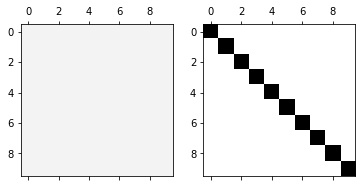

In [ ]:

# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(A_log[0], vmin=0, vmax=1, cmap="Greys")
ax2.matshow(A_log[-1], vmin=0, vmax=1, cmap="Greys")


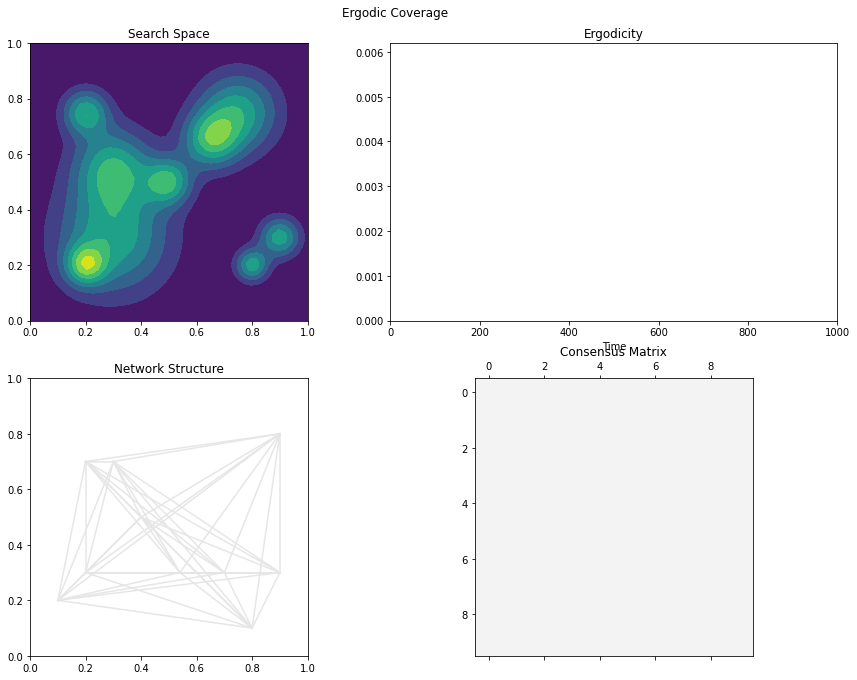

In [ ]:
""" Animate """ 
# colors = ['r', 'm', 'c', 'y', 'g', 'b', 'k', 'w']
colors = ['maroon', 'cyan', 'red', 'black', 'slateblue', 'orange', 'indigo', 'magenta', 'pink', 'white']
if N > len(colors):
    raise NotYetImplemented("Number of agents: ", N, "- Animation of this dimension is not supported.")

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.4*3, 4.8))
fig, ((ax1, ax2), (ax4, ax3)) = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))

fig.suptitle('Ergodic Coverage')


ax1.set_title('Search Space')
ax1.set_aspect('equal')
ax1.set_xlim(0, U_shape[0])
ax1.set_ylim(0, U_shape[1])

X,Y = np.meshgrid(np.linspace(0, U_shape[0]), np.linspace(0, U_shape[1]))
_s = np.stack([X.ravel(), Y.ravel()]).T
ax1.contourf(X, Y, np.array(list(map(mu_dist, _s))).reshape(X.shape))

ax2.set_title('Ergodicity')
ax2.set(xlabel='Time')

ax3.set_title('Consensus Matrix')

ax4.set_title('Network Structure')
ax4.set_aspect('equal')
ax4.set_xlim(0, U_shape[0])
ax4.set_ylim(0, U_shape[1])
fig.tight_layout()

pos_data = [([], []) for i in range(N)]
time_data = []
ergodicity_data = []
local_ergodicity_data = [[] for i in range(N)]
pos_lns = []
local_erg_lns = []

for i in range(N):
    pos_ln, = ax1.plot(pos_data[i][0], pos_data[i][1], c=colors[i], label=i)
    pos_lns.append(pos_ln)

    local_erg, = ax2.plot(time_data, local_ergodicity_data[i], c=colors[i], label=i)
    local_erg_lns.append(local_erg)
ergodicity_ln, = ax2.plot(time_data, ergodicity_data, c='b')
consensus_ln = ax3.matshow(A_log[0], vmin=0, vmax=1, cmap="Greys")

network_lns = []
for i in range(N):
    for j in range(i+1, N):
        network_ln, = ax4.plot([agents[i].x_log[0][0], agents[j].x_log[0][0]], 
                                [agents[i].x_log[0][1], agents[j].x_log[0][1]], 
                                c=str(1 - A_log[0][i][j]), label=(i, j), alpha=A_log[0][i][j])
        network_lns.append(network_ln)

def animate2d_init():
    phi2_max = max(overall_e_log)
    time_max = len(overall_e_log)
    ax2.set_xlim(0, time_max)
    ax2.set_ylim(0, phi2_max)
    return (*network_lns, consensus_ln, ergodicity_ln, *local_erg_lns, *pos_lns)


def animate2d_from_logs_update(frame):
    time_data.append(frame)
    idx = 0
    for i in range(N):
        pos_data[i][0].append(agents[i].x_log[frame][0])
        pos_data[i][1].append(agents[i].x_log[frame][1])
        pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])

        local_ergodicity_data[i].append(agents[i].e_log[frame])
        local_erg_lns[i].set_data(time_data, local_ergodicity_data[i])
        for j in range(i+1, N):
            network_lns[idx].set_data([agents[i].x_log[frame][0], agents[j].x_log[frame][0]], 
                                [agents[i].x_log[frame][1], agents[j].x_log[frame][1]])
            network_lns[idx].set_color(str(1 - A_log[frame][i][j]))
            network_lns[idx].set_alpha(A_log[frame][i][j])
            idx+=1
    
    ergodicity_data.append(overall_e_log[frame])
    ergodicity_ln.set_data(time_data, ergodicity_data)
    consensus_ln.set_data(A_log[frame])

    return (*network_lns, consensus_ln, ergodicity_ln, *local_erg_lns, *pos_lns)



update = animate2d_from_logs_update
frames = len(overall_e_log)


FFwriter = animation.writers['ffmpeg']
writer = FFwriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anime = animation.FuncAnimation(fig, animate2d_from_logs_update, init_func=animate2d_init, 
                            frames=frames, interval=20, blit=True)  
plt.show()
if filename is not None:
    anime.save(filename+".mp4", writer=writer) 

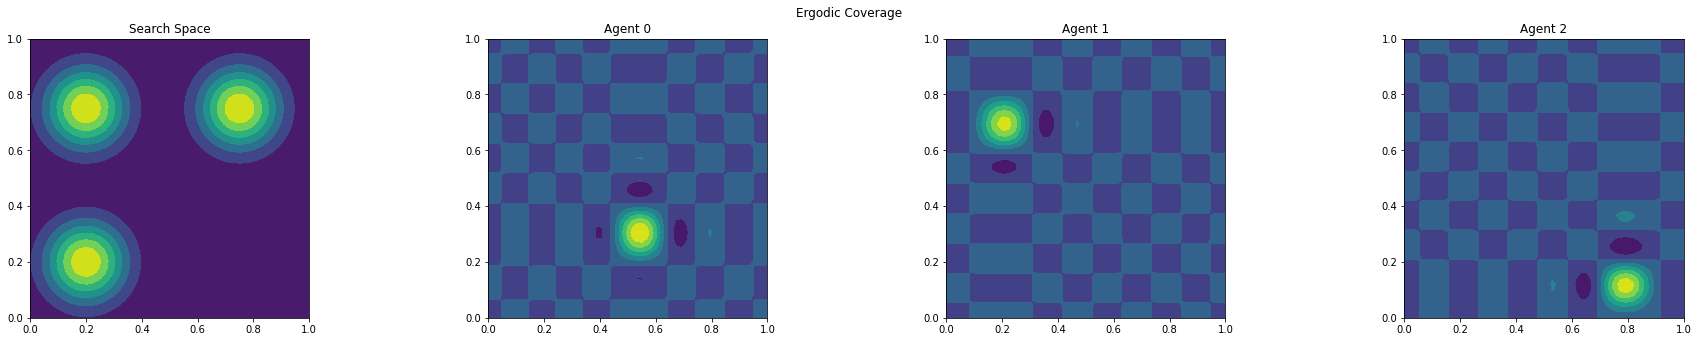

In [ ]:
""" Animate c_k """
frames = 50#500# len(overall_e_log)

fig, (ax0, *ax) = plt.subplots(1, N+1, figsize=(6.4*(N+1), 4.8))
fig.suptitle('Ergodic Coverage')
fig.tight_layout()

ax0.set_title('Search Space')
ax0.set_aspect('equal')
ax0.set_xlim(0, U_shape[0])
ax0.set_ylim(0, U_shape[1])

X,Y = np.meshgrid(np.linspace(0, U_shape[0]), np.linspace(0, U_shape[1]))
_s = np.stack([X.ravel(), Y.ravel()]).T
ax0.contourf(X, Y, np.array(list(map(mu_dist, _s))).reshape(X.shape))

pos_data = [([], []) for i in range(N)]
pos_lns = []
c_k_lns = []
for i in range(N):
    pos_ln, = ax0.plot(pos_data[i][0], pos_data[i][1], c=colors[i], label=i)
    ax[i].set_title(f'Agent {i}')
    pos_lns.append(pos_ln)
    f_c_k = lambda x: sum([agents[i].c_k_log[0][k]*fourier[k](torch.tensor(x)).numpy() for k in agents[i].k_bands])
    ax[i].set_aspect('equal')
    c_k_ln = ax[i].contourf(X, Y, np.array(list(map(f_c_k, _s))).reshape(X.shape))
    c_k_lns.append(c_k_ln) 

def animate2d_init():
    c_k_collections = [c_k_ln.collections for c_k_ln in c_k_lns]
    return (*pos_lns, *c_k_collections)


def animate2d_from_logs_update(frame):
    for i in range(N):
        pos_data[i][0].append(agents[i].x_log[frame][0])
        pos_data[i][1].append(agents[i].x_log[frame][1])
        pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])

        for tp in c_k_lns[i].collections:
            tp.remove()
        f_c_k = lambda x: sum([agents[i].c_k_log[frame][k]*fourier[k](torch.tensor(x)).numpy() for k in agents[i].k_bands])
        c_k_lns[i] = ax[i].contourf(X, Y, np.array(list(map(f_c_k, _s))).reshape(X.shape))
        c_k_collections = [c_k_ln.collections for c_k_ln in c_k_lns]
    return (*pos_lns, *c_k_collections)


update = animate2d_from_logs_update
# frames = len(overall_e_log)


FFwriter = animation.writers['ffmpeg']
writer = FFwriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anime = animation.FuncAnimation(fig, animate2d_from_logs_update, init_func=animate2d_init, 
                            frames=frames, interval=20, blit=False)  

plt.show()
if filename is not None:
    anime.save(filename+"c_k_recon.mp4", writer=writer) 


In [ ]:
# Spectral Decomposition
# K = 10
# Low 8 Mid 10 High 12
low = list(filter(lambda x: sum(x) < 8, np.ndindex(*[10]*2)))
high = list(filter(lambda x: sum(x) >= 8, np.ndindex(*[10]*2)))
print(len(low))
print(len(high))
f = mm_ergodic.functions
def create_band(band_k):
    return lambda x: sum([f[k]['mu_k']*f[k]['fourier_k'](torch.tensor(x)).numpy() for k in band_k])
low_band = create_band(low)
high_band = create_band(high)
recon_band = lambda x: low_band(x) + high_band(x)


fig, axes = plt.subplots(1, 4, figsize=(12+3, 3))
titles = ['Normal', 'Low', 'High', 'Reconstructed']
maps = [p1, low_band, high_band, recon_band]

fig.suptitle('Search Space')
fig.tight_layout()
levels = list(np.array(range(-4, 12))/2)
for i in range(len(axes)): 
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_aspect('equal')
    space = 1e-2
    ax.set_xlim(0-space, 1+space)
    ax.set_ylim(0-space, 1+space)
   
    X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
    _s = np.stack([X.ravel(), Y.ravel()]).T

    
    q = ax.contourf(X, Y, np.array(list(map(maps[i], _s))).reshape(X.shape), levels=levels)  
    if levels is None:
        levels = q.levels
        print(levels)

plt.subplots_adjust(right=0.875)
cbar_ax = fig.add_axes([0.9, 0.05, 0.01, 0.8])
plt.colorbar(q, cax=cbar_ax)
plt.show()

36
64


NameError: name 'mm_ergodic' is not defined